In [ ]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from skimage.feature import graycomatrix, graycoprops
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from scipy.stats import entropy
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

In [ ]:
data = []
labels = []
paths = []
file_name = []

for sub_folder in os.listdir("/content/dadata"):
    sub_folder_path = os.path.join("/content/dadata", sub_folder)
    sub_folder_files = os.listdir(sub_folder_path)
    for i, filename in enumerate(sub_folder_files):
        # Skip hidden files or system files
        if filename.startswith('.') or filename.startswith('_'):
            continue

        img_path = os.path.join(sub_folder_path, filename)
        img = cv.imread(img_path)

        # Check if the image was successfully loaded
        if img is not None:
            img = img.astype(np.uint8)
            data.append(img)
            labels.append(sub_folder)
            paths.append(img_path)
            name = os.path.splitext(filename)[0]
            file_name.append(filename)
        else:
            print(f"Warning: Unable to read image at path: {img_path}")

data = np.array(data)
labels = np.array(labels)
paths = np.array(paths)

print(len(data), len(labels), len(paths))

800 800 800


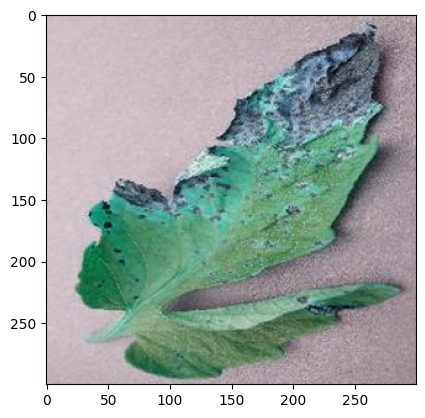

In [ ]:
plt.imshow(data[123], cmap='gray')

In [ ]:
def convert_to_grayscale(img):
    gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    return gray_img

In [ ]:
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []

for i in range(len(data)):
    # Original image
    data_augmented.append(convert_to_grayscale(data[i]))
    labels_augmented.append(labels[i])
    paths_augmented.append(paths[i])
    file_name_augmented.append(file_name[i])

    # 90 degrees rotation
    rotated_90 = cv.rotate(data[i], cv.ROTATE_90_CLOCKWISE)
    data_augmented.append(convert_to_grayscale(rotated_90))
    labels_augmented.append(labels[i])
    paths_augmented.append(paths[i])
    file_name_augmented.append(file_name[i])

    # 180 degrees rotation
    rotated_180 = cv.rotate(data[i], cv.ROTATE_180)
    data_augmented.append(convert_to_grayscale(rotated_180))
    labels_augmented.append(labels[i])
    paths_augmented.append(paths[i])
    file_name_augmented.append(file_name[i])

    # 270 degrees rotation
    rotated_270 = cv.rotate(data[i], cv.ROTATE_90_COUNTERCLOCKWISE)
    data_augmented.append(convert_to_grayscale(rotated_270))
    labels_augmented.append(labels[i])
    paths_augmented.append(paths[i])
    file_name_augmented.append(file_name[i])

print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  800
Data setelah augmentasi:  3200


#PREPREPREPREPRE

1. equalization
2. edge detection
3. sharpening
4. smootihing
5. Treshold
6. closing

In [ ]:
def equalize_histogram(img):
    histogram, bin_edges = np.histogram(img.flatten(), 256, [0, 256])
    cdf = histogram.cumsum()
    cdf_normalized = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())
    cdf_mapped = np.uint8(cdf_normalized[img])
    return cdf_mapped

for i in range(len(data_augmented)):
    data_augmented[i] = equalize_histogram(data_augmented[i])


In [ ]:
print("Jumlah gambar setelah ekualisasi histogram: ", len(data_augmented))

Jumlah gambar setelah ekualisasi histogram:  3200


In [ ]:
def konvolusi(image, kernel):
    pad_size = kernel.shape[0] // 2
    gambar_input = np.pad(image, pad_size, mode='constant')
    gambar_konvolusi = np.zeros_like(image).astype(np.float32)
    baris, kolom = image.shape

    for i in range(baris):
        for j in range(kolom):
            gambar_konvolusi[i, j] = np.sum(gambar_input[i:i + kernel.shape[0], j:j + kernel.shape[1]] * kernel)

    return gambar_konvolusi



In [ ]:
def MagnitudeR(x, y):
    return np.sqrt(np.square(x) + np.square(y))

In [ ]:
px = np.array([[-1, 0, 1],
            [-1, 0, 1],
            [-1, 0, 1]])
py = np.array([[1, 1, 1],
            [0, 0, 0],
            [-1, -1, -1]])
kernelsmooth = np.array([[1/9, 1/9, 1/9],
                        [1/9, 8/9, 1/9],
                        [1/9, 1/9, 1/9]])

kernelsharp = np.array([[1/10, 1/10, 1/10],
                        [1/10, 1/5, 1/10],
                        [1/10, 1/10, 1/10]])

In [ ]:
from tqdm import tqdm

In [ ]:
for i in tqdm(range(len(data_augmented)), desc="Menghitung Gradien Magnitude"):
    grad_x = konvolusi(data_augmented[i], px)
    grad_y = konvolusi(data_augmented[i], py)
    magnitude = MagnitudeR(grad_x, grad_y)
    data_augmented[i] = magnitude

Menghitung Gradien Magnitude: 100%|██████████| 3200/3200 [1:23:25<00:00,  1.56s/it]


In [ ]:
print("Jumlah : ", len(data_augmented))

Jumlah :  3200


In [ ]:
for i in tqdm(range(len(data_augmented)), desc="Membuat Sharpening"):
    sharp = konvolusi(data_augmented[i], kernelsharp)
    data_augmented[i] = sharp

Membuat Sharpening: 100%|██████████| 3200/3200 [41:10<00:00,  1.30it/s]


In [28]:
for i in tqdm(range(len(data_augmented)), desc="Membuat Sharpening"):
    smooth = konvolusi(data_augmented[i], kernelsmooth)
    data_augmented[i] = smooth

Membuat Sharpening: 100%|██████████| 3200/3200 [40:05<00:00,  1.33it/s]


In [60]:
def nothing(img):
    return img

In [61]:
for i in tqdm(range(len(data_augmented)), desc="Menerapkan Threshold"):
    data_augmented[i] = nothing(data_augmented[i])

Menerapkan Threshold: 100%|██████████| 3200/3200 [00:00<00:00, 639040.75it/s]


# MODELTRAINTESTEVAL

In [62]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")

    # Convert image to unsigned integer type
    image = image.astype(np.uint8)

    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [63]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [64]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []

for i in tqdm(range(len(data_augmented)), desc="Calculating GLCM"):
    D0 = glcm(data_augmented[i], 0)
    D45 = glcm(data_augmented[i], 45)
    D90 = glcm(data_augmented[i], 90)
    D135 = glcm(data_augmented[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Calculating GLCM: 100%|██████████| 3200/3200 [00:09<00:00, 342.08it/s]


In [65]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [66]:
for i in range(len(data)):
    C0 = correlation(Derajat0[i])
    C45 = correlation(Derajat45[i])
    C90 = correlation(Derajat90[i])
    C135 = correlation(Derajat135[i])
    correlation0.append(C0)

    correlation45.append(C45)

    correlation90.append(C90)

    correlation135.append(C135)

In [67]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [68]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [69]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [70]:
for i in range(len(data)):
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [71]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [72]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [73]:
# Memeriksa panjang setiap array
print("Filename length:", len(file_name))
print("Label length:", len(labels))
print("Contrast0 length:", len(Kontras0))
print("Contrast45 length:", len(Kontras45))
print("Contrast90 length:", len(Kontras90))
print("Contrast135 length:", len(Kontras135))
print("Homogeneity0 length:", len(homogenity0))
print("Homogeneity45 length:", len(homogenity45))
print("Homogeneity90 length:", len(homogenity90))
print("Homogeneity135 length:", len(homogenity135))
print("Dissimilarity0 length:", len(dissimilarity0))
print("Dissimilarity45 length:", len(dissimilarity45))
print("Dissimilarity90 length:", len(dissimilarity90))
print("Dissimilarity135 length:", len(dissimilarity135))
print("Entropy0 length:", len(entropy0))
print("Entropy45 length:", len(entropy45))
print("Entropy90 length:", len(entropy90))
print("Entropy135 length:", len(entropy135))
print("ASM0 length:", len(ASM0))
print("ASM45 length:", len(ASM45))
print("ASM90 length:", len(ASM90))
print("ASM135 length:", len(ASM135))
print("Energy0 length:", len(energy0))
print("Energy45 length:", len(energy45))
print("Energy90 length:", len(energy90))
print("Energy135 length:", len(energy135))
print("Correlation0 length:", len(correlation0))
print("Correlation45 length:", len(correlation45))
print("Correlation90 length:", len(correlation90))
print("Correlation135 length:", len(correlation135))


Filename length: 800
Label length: 800
Contrast0 length: 800
Contrast45 length: 800
Contrast90 length: 800
Contrast135 length: 800
Homogeneity0 length: 800
Homogeneity45 length: 800
Homogeneity90 length: 800
Homogeneity135 length: 800
Dissimilarity0 length: 800
Dissimilarity45 length: 800
Dissimilarity90 length: 800
Dissimilarity135 length: 800
Entropy0 length: 800
Entropy45 length: 800
Entropy90 length: 800
Entropy135 length: 800
ASM0 length: 800
ASM45 length: 800
ASM90 length: 800
ASM135 length: 800
Energy0 length: 800
Energy45 length: 800
Energy90 length: 800
Energy135 length: 800
Correlation0 length: 800
Correlation45 length: 800
Correlation90 length: 800
Correlation135 length: 800


In [93]:
dataTable = {
    'Filename': file_name,
    'Label': labels,
    'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
    'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
    'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
    'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
    'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
    'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
    'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
}

In [94]:
df = pd.DataFrame(dataTable)
df.to_csv('hasil_0.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_0.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,Tomato___Septoria_leaf_spot_199.jpg,tomato_septoria_leaf_spot,3525.993311,5159.028702,3910.198997,5204.123835,0.945776,0.920662,0.939867,0.919969,...,0.661209,0.643887,0.816251,0.802789,0.813147,0.802426,0.808018,0.719139,0.786966,0.716684
1,Tomato___Septoria_leaf_spot_34.jpg,tomato_septoria_leaf_spot,3910.198997,5204.123835,3525.993311,5159.028702,0.939867,0.919969,0.945776,0.920662,...,0.666265,0.644470,0.813147,0.802426,0.816251,0.802789,0.786966,0.716684,0.808018,0.719139
2,Tomato___Septoria_leaf_spot_189.jpg,tomato_septoria_leaf_spot,3525.993311,5159.028702,3910.198997,5204.123835,0.945776,0.920662,0.939867,0.919969,...,0.661209,0.643887,0.816251,0.802789,0.813147,0.802426,0.808018,0.719139,0.786966,0.716684
3,Tomato___Septoria_leaf_spot_36.jpg,tomato_septoria_leaf_spot,3910.198997,5204.123835,3525.993311,5159.028702,0.939867,0.919969,0.945776,0.920662,...,0.666265,0.644470,0.813147,0.802426,0.816251,0.802789,0.786966,0.716684,0.808018,0.719139
4,Tomato___Septoria_leaf_spot_178.jpg,tomato_septoria_leaf_spot,3961.668060,5749.629478,3976.891304,5315.406986,0.939076,0.911580,0.938842,0.918257,...,0.456182,0.438096,0.675492,0.657690,0.675412,0.661888,0.874767,0.818376,0.874261,0.832093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,Tomato___Bacterial_spot_32.jpg,tomato_bacterial_spot,5342.633779,7055.206318,5014.971572,7177.399582,0.917838,0.891502,0.922877,0.889623,...,0.580965,0.553119,0.759426,0.744706,0.762210,0.743720,0.763805,0.688832,0.778291,0.683442
796,Tomato___Bacterial_spot_29.jpg,tomato_bacterial_spot,4349.498328,5798.361316,4153.770903,5894.370309,0.933111,0.910830,0.936121,0.909354,...,0.678074,0.654727,0.821862,0.809900,0.823453,0.809152,0.744820,0.660742,0.756303,0.655125
797,Tomato___Bacterial_spot_36.jpg,tomato_bacterial_spot,4153.770903,5894.370309,4349.498328,5798.361316,0.936121,0.909354,0.933111,0.910830,...,0.675458,0.655938,0.823453,0.809152,0.821862,0.809900,0.756303,0.655125,0.744820,0.660742
798,Tomato___Bacterial_spot_8.jpg,tomato_bacterial_spot,4349.498328,5798.361316,4153.770903,5894.370309,0.933111,0.910830,0.936121,0.909354,...,0.678074,0.654727,0.821862,0.809900,0.823453,0.809152,0.744820,0.660742,0.756303,0.655125


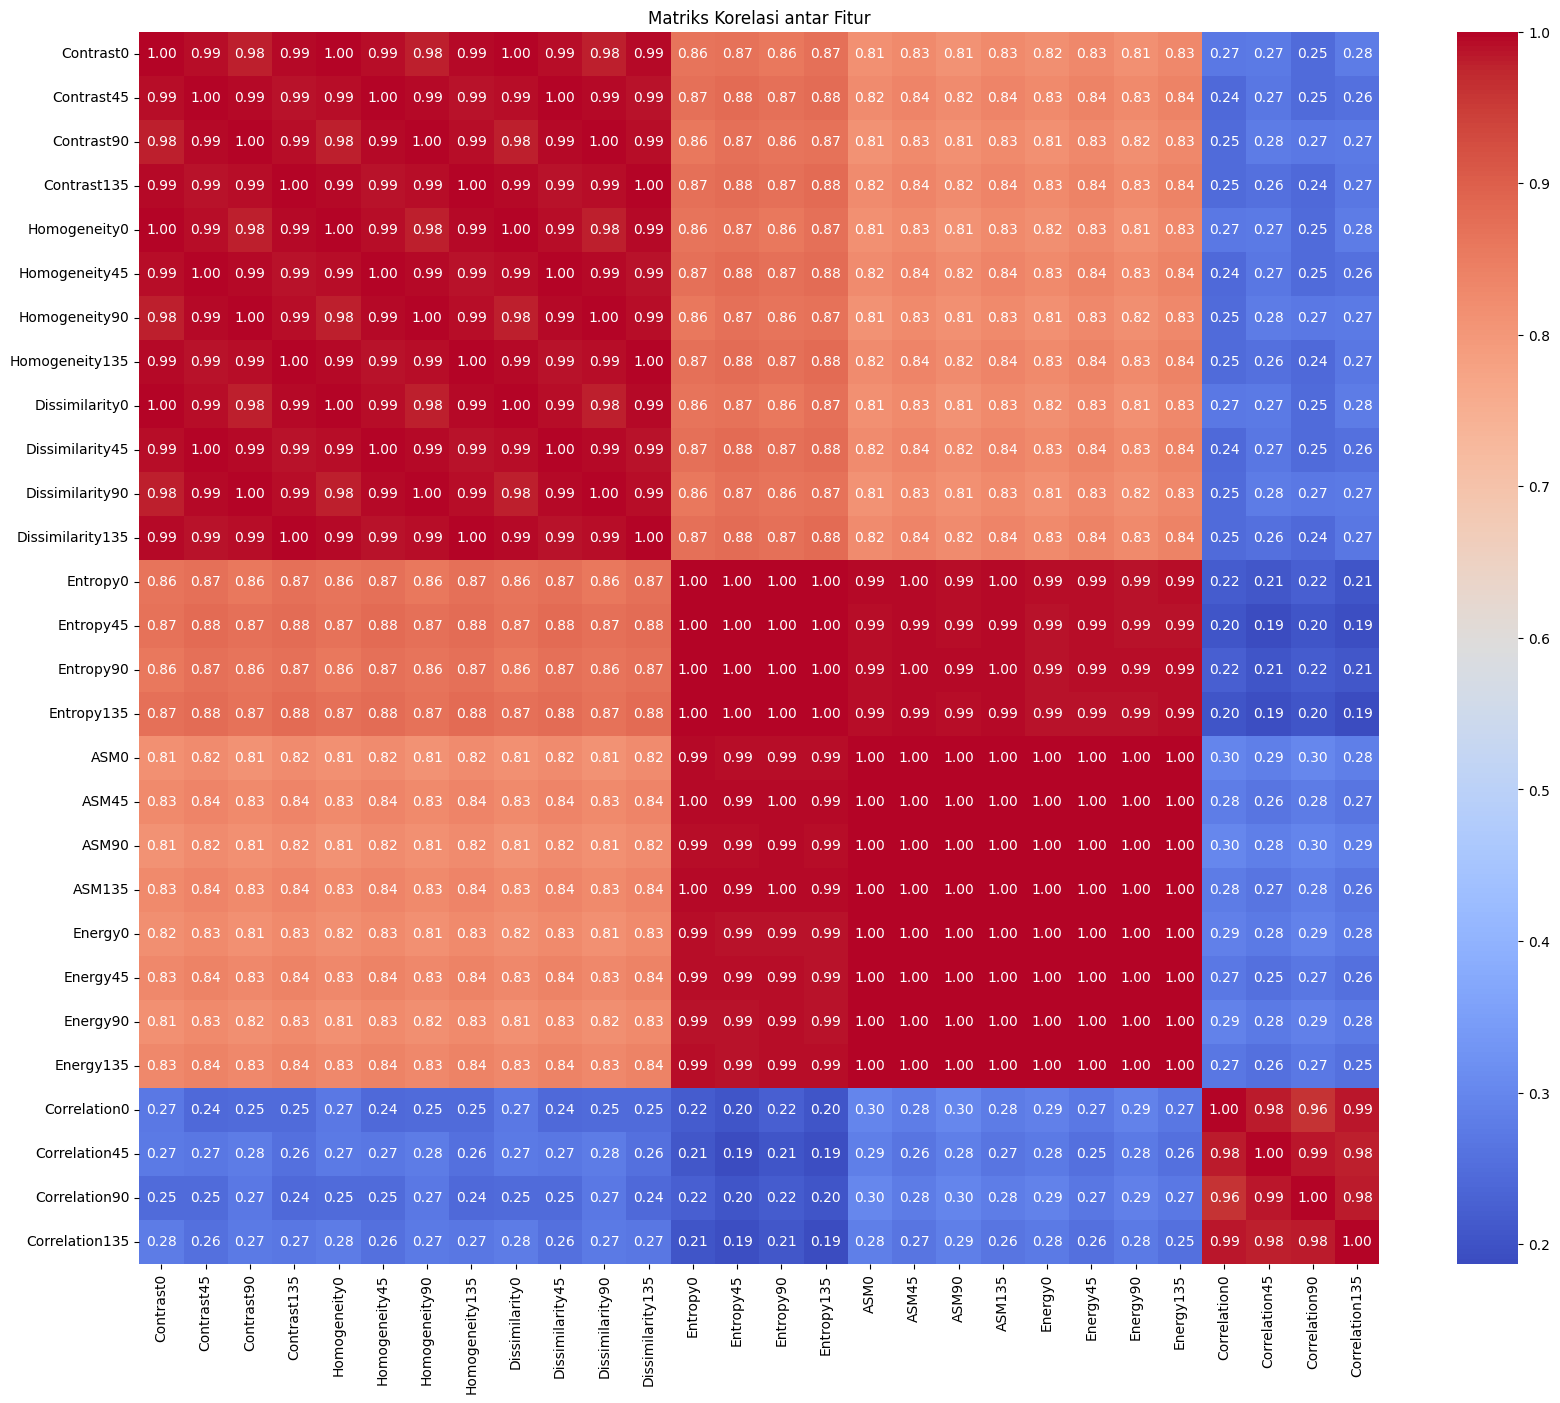

In [95]:
numeric_cols = hasilEkstrak.select_dtypes(include='number')
correlation_matrix = numeric_cols.corr().abs()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriks Korelasi antar Fitur')
plt.show()

In [99]:
XX = hasilEkstrak.drop(columns=['Label','Filename'])
yy = hasilEkstrak['Label']

X_train, X_test, y_train, y_test = train_test_split(XX, yy, test_size=0.20, random_state=42)

In [100]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [101]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [102]:
report_rf = classification_report(y_test, y_pred_rf)
print("Report Random Forest")
print(report_rf)

Report Random Forest
                           precision    recall  f1-score   support

    tomato_bacterial_spot       0.85      0.78      0.81        45
      tomato_early_blight       0.82      0.86      0.84        43
           tomato_healthy       0.78      0.83      0.81        35
tomato_septoria_leaf_spot       0.89      0.89      0.89        37

                 accuracy                           0.84       160
                macro avg       0.84      0.84      0.84       160
             weighted avg       0.84      0.84      0.84       160

